Projeto de predição de grau de estado deterioração do figado devido ao HCV

Equipe: Daniel Lemos,
        Rafael Targino
        
Data_Set: https://archive.ics.uci.edu/ml/machine-learning-databases/00503/HCV-Egy-Data.zip


Passos:
Ler os dados e normalizá-los cross-validation 10 folds
Utilizar os seguintes algoritimos:
1- KNN variando o K(1,3,5,10)
2- Naive-Bayes
3- Arvore de Decisão (Random Forrest) variando o numero de florestas
4- RLScore(variando o numero de kernels)

In [6]:
!pip install rlscore
import numpy as np
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline

Base de dados de pacientes egípcios que foram submetidos a doses de tratamento para HCV cerca de 18 meses. A discretização deve ser aplicada com base em recomendações de especialistas; há um arquivo anexado mostra como.

A base de dados reúne cerca de 

Os dados apresentão o estágio inicial da entrada dos pacientes e as taxas , o problema é diagnosticar o grau de degradação do fígado através dos exames previamente levantados, sem a necessidade de exame de ultrasom ou histológico, ou seja prever o resultado do exame histológio acelerando assim que tipo de tratamento aplicar.
as classes são não fibroso que significa saldável, fibroso, fibroso com poucas cepas do vírus, fibroso com muitas cepas e cirrose.


AxesSubplot(0.125,0.125;0.775x0.755)
      Age   Gender  ...  Baseline histological Grading  Baselinehistological staging
0     56.0     1.0  ...                           13.0                           2.0
1     46.0     1.0  ...                            4.0                           2.0
2     57.0     1.0  ...                            4.0                           4.0
3     49.0     2.0  ...                           10.0                           3.0
4     59.0     1.0  ...                           11.0                           1.0
...    ...     ...  ...                            ...                           ...
1323  59.0     1.0  ...                           16.0                           2.0
1324  46.0     1.0  ...                           11.0                           2.0
1325  52.0     2.0  ...                           16.0                           2.0
1326  55.0     1.0  ...                           10.0                           2.0
1327  42.0     1.0  ...     

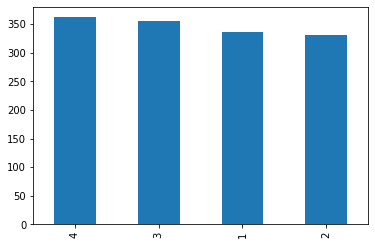

In [7]:
df = pd.read_csv("https://drive.google.com/uc?authuser=0&id=1S2HnHU5zoI7ERYhVd8naSaUMt0eJZW3L&export=download")

columns = df.columns


ax = df['Baselinehistological staging'].value_counts().plot.bar()
print(ax)
classes = df['Baselinehistological staging'].unique()

index_amostra= list()
index_1 = 0
index_3 = 0
index_4 = 0
index_2 = 0
for x in df.index:
  if index_2<332:
    if df.loc[x,'Baselinehistological staging'] == 2:
      index_amostra.append(x)
      index_2= index_2+1
  if index_4<332:    
    if df.loc[x,'Baselinehistological staging'] == 4:
      index_amostra.append(x)
      index_4 = index_4 +1
  if index_3<332:
    if df.loc[x,'Baselinehistological staging'] == 3:
      index_amostra.append(x)
      index_3 = index_3 +1
  if index_1<332:
    if df.loc[x,'Baselinehistological staging'] ==1:
      index_amostra.append(x)
      index_1 = index_1 +1
dfAvalues = []
for g in index_amostra:
  dfAvalues.append(df.iloc[g].values)

dfAmostra = pd.DataFrame(dfAvalues,columns=columns)
print(dfAmostra)


Preparação dos dados de três formas diferentes, sendo escalados entre 0 e 1, valores absolutos  e normalizados, gerando três dataframes diferentes para os testes, separação das labels do Features.

AxesSubplot(0.125,0.125;0.775x0.755)


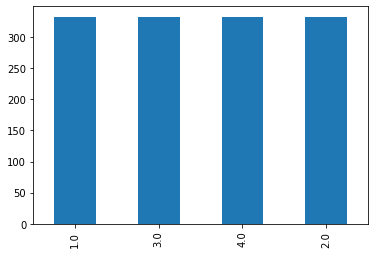

In [105]:
from sklearn import preprocessing
dfclass = pd.Series(dfAmostra['Baselinehistological staging'])
dfsclass = pd.DataFrame(dfAmostra.iloc[:,0:28]) 

columns = dfsclass.columns
ax = dfclass.value_counts().plot.bar()
print(ax)

repcolumns = list()
for index, column in enumerate(columns):
  column = column.replace(" ","")
  repcolumns.append(column)
x = dfsclass.values
x_scale = preprocessing.scale(dfsclass)
x_normal = preprocessing.normalize(dfsclass, norm='l1')
min_max_scaler = preprocessing.MinMaxScaler()
max_abs_scaler = preprocessing.MaxAbsScaler()
x_scaled = min_max_scaler.fit_transform(dfsclass)
x_abs = max_abs_scaler.fit_transform(dfsclass)


dfnorm = pd.DataFrame(x_normal, columns = repcolumns)
df_abs = pd.DataFrame(x_abs, columns = repcolumns)
df_scale = pd.DataFrame(x_scaled, columns = repcolumns)

dfL = {'Normalizado': dfnorm,'Valor_Absoluto': df_abs,'Escalado': df_scale}




Geração dos kfolds

In [0]:

def TesteNB(dfL,dl,skf):
  from sklearn.model_selection import cross_val_score
  import numpy
  Result_cross_valG =[]
  Result_cross_valM =[]
  Result_AcG = []
  Result_AcM = []
  for Features, Labels in skf.split(dfL[dl],dfclass):
    X_train, X_test = dfL[dl].iloc[Features], dfL[dl].iloc[Labels]
    y_train, y_test = dfclass.iloc[Features], dfclass.iloc[Labels]
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_predG = gnb.predict(X_test)
    acuG = metrics.accuracy_score(y_test, y_predG)
    Result_cross_valG.append(max(cross_val_score(gnb,dfL[dl],dfclass,cv=10)))
    
    if Result_AcG != []:
      if max(Result_AcG)<acuG:
        Result_AcG.append(acuG)
    else:
      Result_AcG.append(acuG)

    gnm = MultinomialNB()
    gnm.fit(X_train, y_train)
    y_predM = gnb.predict(X_test)
    acuM = metrics.accuracy_score(y_test,y_predM)
    Result_cross_valM.append(max(cross_val_score(gnm,dfL[dl],dfclass,cv=10)))
    if Result_AcM != []:
      if max(Result_AcM)<acuM:
        Result_AcM.append(acuM)
    else:
      Result_AcM.append(acuM)

  Result_cross_in_NBG = max(Result_cross_valG)
  Result_cross_in_NBM = max(Result_cross_valM)
  
  
  

  return [Result_cross_in_NBG,Result_cross_in_NBM]



In [0]:
from rlscore.learner import LeaveOneOutRLS
from rlscore.measure import ova_accuracy
from rlscore.utilities.multiclass import to_one_vs_all
def Testerls(dfL, dl, skf):
  Result_Acu=[]
  Result_cross_RLS=[]
  for Features, Labels in skf.split(dfL[dl],dfclass):
    X_train, X_test = dfL[dl].iloc[Features], dfL[dl].iloc[Labels]
    y_train, y_test = dfclass.iloc[Features], dfclass.iloc[Labels]
    y_train = to_one_vs_all(y_train, False)
    y_test = to_one_vs_all(y_test, False)
    regparams = [2.**i for i in range(-15, 16)]
    learner = LeaveOneOutRLS(X_train, y_train, regparams=regparams, measure=ova_accuracy)
    P_test = learner.predict(X_test)
    acu = ova_accuracy(y_test, P_test)
    
    if Result_Acu != []:
      if max(Result_Acu)<acu:
        Result_Acu.append(acu)
    else:
      Result_Acu.append(acu)
  return max(Result_Acu)


/usr/local/lib/python3.6/dist-packages/rlscore/utilities/array_tools.py:43: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(A.dtype, int) and not np.issubdtype(A.dtype, float):
/usr/local/lib/python3.6/dist-packages/rlscore/utilities/array_tools.py:43: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(A.dtype, int) and not np.issubdtype(A.dtype, float):
/usr/local/lib/python3.6/dist-packages/rlscore/utilities/array_tools.py:43: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(A.dtype, int) and not np.issubdtype(A.dtype, float):
/usr/loca

{'Normalizado': [0.3181818181818182, 0.30303030303030304], 'Valor_Absoluto': [0.3106060606060606, 0.2878787878787879], 'Escalado': [0.3106060606060606, 0.3333333333333333]}
{'Normalizado': 0.3484848484848485, 'Valor_Absoluto': 0.2803030303030303, 'Escalado': 0.26515151515151514}
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


'for dl in dfL:\n  \n   \n\n    gnb = GaussianNB()\n    gnb.fit(X_train, y_train)\n    y_pred = gnb.predict(X_test)\n    acu = metrics.accuracy_score(y_test, y_pred)\n    print(\'Accuracy GaussianNB: {}\'.format(acu))\n\n    gnb = MultinomialNB()\n    gnb.fit(X_train, y_train)\n    y_pred = gnb.predict(X_test)\n    print(\'Accuracy MultinominalNB: {}\'.format(metrics.accuracy_score(y_test, y_pred)))\n\n    for n in estimators:\n      rf = RandomForestClassifier(n_estimators=n)\n      rf.fit(X_train,y_train)\n      predictions = rf.predict(X_test)\n      print(\'Accuracy com estimator {} : {}\'.format(n,metrics.accuracy_score(y_test, predictions)))\n\n\n    y_train = to_one_vs_all(y_train, False)\n    y_test = to_one_vs_all(y_test, False)\n    regparams = [2.**i for i in range(-15, 16)]\n    learner = LeaveOneOutRLS(X_train, y_train, regparams=regparams, measure=ova_accuracy)\n    P_test = learner.predict(X_test)\n      \n    print("test set accuracy {}".format(ova_accuracy(y_test, P_te

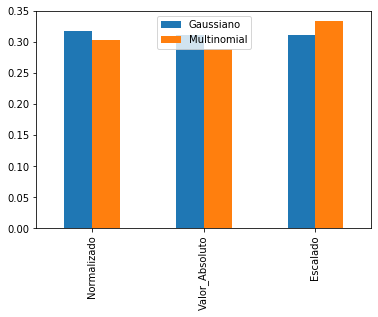

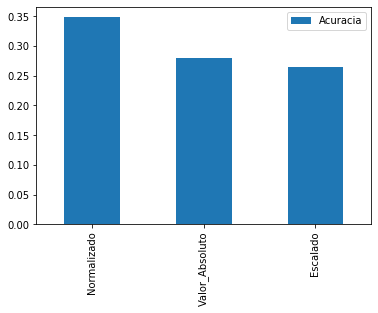

In [173]:
#from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from rlscore.learner import LeaveOneOutRLS
from rlscore.measure import ova_accuracy
from rlscore.utilities.multiclass import to_one_vs_all
from sklearn import metrics


from sklearn.model_selection import cross_val_score

skf = StratifiedKFold(n_splits=10,shuffle=True)
Resultado_NB={}
Resultado_Rls={}
Resultado_Rf = {}
X_index = dfnorm.index
Y_index = dfclass.index
estimators =[100,200,500,800]
neighbors = [1,3,5,10]



for dl in dfL:
  Resultado_NB[dl] = TesteNB(dfL,dl,skf)
  Resultado_Rls[dl] =Testerls(dfL,dl,skf)
  #Resultado_Rf[dl] = TesteRF(dfL,dl,skf)
print(Resultado_NB)
print(Resultado_Rls)  

Resul_NB = pd.DataFrame(Resultado_NB.values(),columns=['Gaussiano','Multinomial'],index=['Normalizado','Valor_Absoluto','Escalado'])
Resul_NB.to_csv('AcuNB.csv',sep='\t', encoding='utf-8')
Resul_Rls = pd.DataFrame(Resultado_Rls.values(),index=['Normalizado', 'Valor_Absoluto','Escalado'],columns=['Acuracia'])

print(Resul_NB.plot.bar())
print(Resul_Rls.plot.bar())

'''for dl in dfL:
  
   

    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    acu = metrics.accuracy_score(y_test, y_pred)
    print('Accuracy GaussianNB: {}'.format(acu))

    gnb = MultinomialNB()
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    print('Accuracy MultinominalNB: {}'.format(metrics.accuracy_score(y_test, y_pred)))

    for n in estimators:
      rf = RandomForestClassifier(n_estimators=n)
      rf.fit(X_train,y_train)
      predictions = rf.predict(X_test)
      print('Accuracy com estimator {} : {}'.format(n,metrics.accuracy_score(y_test, predictions)))


    y_train = to_one_vs_all(y_train, False)
    y_test = to_one_vs_all(y_test, False)
    regparams = [2.**i for i in range(-15, 16)]
    learner = LeaveOneOutRLS(X_train, y_train, regparams=regparams, measure=ova_accuracy)
    P_test = learner.predict(X_test)
      
    print("test set accuracy {}".format(ova_accuracy(y_test, P_test)) )

    
  
    y_train = to_one_vs_all(y_train, False)
    y_test = to_one_vs_all(y_test, False)
    regparams = [2.**i for i in range(-15, 16)]
    learner = LeaveOneOutRLS(X_train, y_train, regparams=regparams, measure=ova_accuracy)
    P_test = learner.predict(X_test)
      
    print("test set accuracy {}".format(ova_accuracy(y_test, P_test)) )

    for n in neighbors:
      
      neigh = KNeighborsClassifier(n_neighbors=n)
      neigh.fit(X_train, y_train)
      y_predic = neigh.predict(X_test,y_test)
  '''


In [131]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

def TesteRF(dfL,dl,skf):
  
  estimators =[100,200,500,800]
  Result_Acu = {}
  Result_cross_RF ={}
  for Features, Labels in skf.split(dfL[dl],dfclass):
    X_train, X_test = dfL[dl].iloc[Features], dfL[dl].iloc[Labels]
    y_train, y_test = dfclass.iloc[Features], dfclass.iloc[Labels]
    for n in estimators:
      rf = RandomForestClassifier(n_estimators=n)
      rf.fit(X_train,y_train)
      predictions = rf.predict(X_test)
      acu = metrics.accuracy_score(y_test, predictions)
      Result_cross_RF[n]= max(cross_val_score(rf,dfL[dl],dfclass,cv=2))
      if n in Result_Acu:
        if Result_Acu[n]>acu:
            Result_Acu[n]=acu
      else:
        Result_Acu[n]=acu
     
  return(Result_Acu,Result_cross_RF)
print(TesteRF(dfL,dl,skf))
  

KeyboardInterrupt: ignored

Random Forrest

KNN

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

neighbors = [1,3,5,10]

for df in dfL:
  for n in neighbors:
    train_features, test_features, train_labels, test_labels = train_test_split(df, dfclass, test_size = 0.25, random_state = 42)
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(train_features, train_labels)
    y_predic = neigh.predict(test_features)
    acc = accuracy_score(test_labels,y_predic)    
    print(acc)



0.22590361445783133
0.22590361445783133
0.22590361445783133
0.22590361445783133
0.22590361445783133
0.22590361445783133
0.22590361445783133
0.22590361445783133
0.24096385542168675
0.24096385542168675
0.24096385542168675
0.24096385542168675
